Takes csv file created by data notebook to drop instances, drop features if too much missing, checks and fixes formatting

In [160]:
import numpy as np
import pandas as pd
from sklearn.impute import SimpleImputer

from load import read_csv, to_csv
from utilities import replace, mean_impute

In [161]:
path = './Data/bt.csv'

In [162]:
df = read_csv(path)
print(len(df))
pd.set_option('display.max_columns', None)
df.head()

94259


,TUMOURID,PATIENTID,DIAGNOSISDATEBEST,SITE_ICD10_O2,SITE_ICD10_O2_3CHAR,MORPH_ICD10_O2,BEHAVIOUR_ICD10_O2,T_BEST,N_BEST,M_BEST,STAGE_BEST,STAGE_BEST_SYSTEM,GRADE,AGE,SEX,CREG_CODE,LINKNUMBER,SCREENINGSTATUSFULL_CODE,ER_STATUS,ER_SCORE,PR_STATUS,PR_SCORE,HER2_STATUS,CANCERCAREPLANINTENT,PERFORMANCESTATUS,CNS,ACE27,GLEASON_PRIMARY,GLEASON_SECONDARY,GLEASON_TERTIARY,GLEASON_COMBINED,DATE_FIRST_SURGERY,LATERALITY,QUINTILE_2015,TUMOUR_COUNT,ETHNICITY,DEATHCAUSECODE_1A,DEATHCAUSECODE_1B,DEATHCAUSECODE_1C,DEATHCAUSECODE_2,DEATHCAUSECODE_UNDERLYING,DEATHLOCATIONCODE,NEWVITALSTATUS,VITALSTATUSDATE,MERGED_PATIENT_ID,SACT,MERGED_TUMOUR_ID,DATE_DECISION_TO_TREAT,START_DATE_OF_REGIMEN,CLINICAL_TRIAL,CHEMO_RADIATION,REGIMEN_COUNT,CLINICAL_TRIAL_INDICATOR,CHEMO_RADIATION_INDICATOR,NORMALISED_HEIGHT,NORMALISED_WEIGHT,MERGED_CYCLE_ID,CYCLE_NUMBER,START_DATE_OF_CYCLE,NEWVITALSTATUSDATE
0,10614165,10501771,2017-01-16,C719,C71,9440,3,NaN,NaN,NaN,U,NaN,G4,69.0,1,L0401,810501771,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2017-01-16,R,4,2,A,NaN,NaN,NaN,NaN,NaN,NaN,A,2019-02-06,NaN,<NA>,NaN,NaT,NaT,False,False,NaN,<NA>,<NA>,NaN,NaN,NaN,NaN,NaT,2019-02-06
1,10614166,10501772,2015-11-10,C712,C71,9440,3,NaN,NaN,NaN,U,NaN,G4,88.0,1,L1001,810501772,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9,NaN,NaN,NaN,NaN,NaN,NaN,2015-11-10,R,1 - least deprived,2,A,"C719,D432",NaN,NaN,NaN,C719,NaN,D,2015-11-27,10501772.0,True,10002483.0,2015-12-15,2015-12-23,False,False,1.0,False,False,1.755,71.75,10003933.0,1.0,2016-06-15,2016-06-15
2,10614166,10501772,2015-11-10,C712,C71,9440,3,NaN,NaN,NaN,U,NaN,G4,88.0,1,L1001,810501772,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9,NaN,NaN,NaN,NaN,NaN,NaN,2015-11-10,R,1 - least deprived,2,A,"C719,D432",NaN,NaN,NaN,C719,NaN,D,2015-11-27,10501772.0,True,10002483.0,2015-12-15,2015-12-23,False,False,1.0,False,False,1.755,71.75,10012207.0,2.0,2016-07-06,2016-07-06
3,10614166,10501772,2015-11-10,C712,C71,9440,3,NaN,NaN,NaN,U,NaN,G4,88.0,1,L1001,810501772,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9,NaN,NaN,NaN,NaN,NaN,NaN,2015-11-10,R,1 - least deprived,2,A,"C719,D432",NaN,NaN,NaN,C719,NaN,D,2015-11-27,10501772.0,True,10002483.0,2015-12-15,2015-12-23,False,False,1.0,False,False,1.755,71.75,10017672.0,2.0,2016-08-03,2016-08-03
4,10614166,10501772,2015-11-10,C712,C71,9440,3,NaN,NaN,NaN,U,NaN,G4,88.0,1,L1001,810501772,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9,NaN,NaN,NaN,NaN,NaN,NaN,2015-11-10,R,1 - least deprived,2,A,"C719,D432",NaN,NaN,NaN,C719,NaN,D,2015-11-27,10501772.0,True,10002483.0,2015-12-15,2015-12-23,False,False,1.0,False,False,1.755,71.75,10021647.0,3.0,2016-08-31,2016-08-31


In [163]:
# to show discrepancy between the 3CHAR code and the regular one 

# df.SITE_ICD10_O2_3CHAR.value_counts()
# df['Reconstructed_3CHAR'] = df['SITE_ICD10_O2'].str[0:3]
# df['Match'] = df['Reconstructed_3CHAR'].isin(df['SITE_ICD10_O2_3CHAR'])
# df['Match'].value_counts()

Drop low height:  5768
Dropped:  5768


array([[<AxesSubplot:title={'center':'NORMALISED_HEIGHT'}>]], dtype=object)

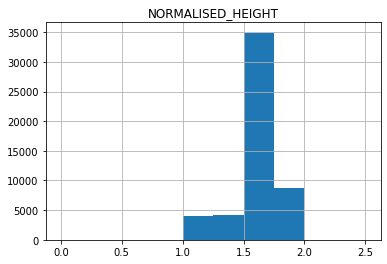

In [164]:
threshold = 1.0

print('Drop low height: ',(df.NORMALISED_HEIGHT < threshold).sum())
len_before = len(df)
df = df.drop(df[df.NORMALISED_HEIGHT < threshold].index)
len_after = len(df)
print('Dropped: ', len_before - len_after)
df.hist(column='NORMALISED_HEIGHT',bins=[0,0.25,0.5,0.75,1.0,1.25,1.5,1.75,2.0,2.25,2.5])


Drop low height:  9074
Dropped:  9074


array([[<AxesSubplot:title={'center':'NORMALISED_WEIGHT'}>]], dtype=object)

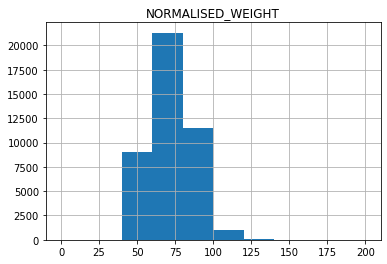

In [165]:
threshold = 40

print('Drop low height: ',(df.NORMALISED_WEIGHT < threshold).sum())
len_before = len(df)
df = df.drop(df[df.NORMALISED_WEIGHT < threshold].index)
len_after = len(df)
print('Dropped: ', len_before - len_after)
df.hist(column='NORMALISED_WEIGHT',bins=[0,20,40,60,80,100,120,140,160,180,200])

In [166]:
vital_alive = df[(df.NEWVITALSTATUS == 'A') | (df.NEWVITALSTATUS == 'X')] 
vital_dead = df[(df.NEWVITALSTATUS == 'D')]
no_death = df[(df.DEATHCAUSECODE_1A.isnull()) &
                (df.DEATHCAUSECODE_1B.isnull()) & 
                (df.DEATHCAUSECODE_1C.isnull()) &
                (df.DEATHCAUSECODE_2.isnull()) &
                (df.DEATHCAUSECODE_UNDERLYING.isnull()) &
                (df.DEATHLOCATIONCODE.isnull())]  
death = df[~df.index.isin(no_death.index)]

alive_but_death = vital_alive[vital_alive.index.isin(death.index)]
dead_but_no_death = vital_dead[vital_dead.index.isin(no_death.index)]

print("".ljust(20), "Death".ljust(10), "No death".ljust(10), "Total")
print("Alive".ljust(20), str(len(alive_but_death)).ljust(10), str(len(vital_alive)-len(alive_but_death)).ljust(10), len(vital_alive))
print("Dead".ljust(20), str(len(vital_dead)-len(dead_but_no_death)).ljust(10), str(len(dead_but_no_death)).ljust(10), len(vital_dead))


                     Death      No death   Total
Alive                16712      20837      37549
Dead                 31149      10719      41868


In [167]:
threshold = 0.15
thresh = round(threshold * len(df))
print(len(df.columns))
print("Feature".ljust(30), "NaNs".ljust(10), "Pct".ljust(10), "Drop?")
for k, v in df.isna().sum(axis = 0).items():
    print(k.ljust(30), str(v).ljust(10), "{:.0%}".format(v/len(df)).ljust(10), v > len(df) - thresh)

60
Feature                        NaNs       Pct        Drop?
TUMOURID                       0          0%         False
PATIENTID                      0          0%         False
DIAGNOSISDATEBEST              0          0%         False
SITE_ICD10_O2                  24         0%         False
SITE_ICD10_O2_3CHAR            30         0%         False
MORPH_ICD10_O2                 73         0%         False
BEHAVIOUR_ICD10_O2             34         0%         False
T_BEST                         77685      98%        True
N_BEST                         77784      98%        True
M_BEST                         77749      98%        True
STAGE_BEST                     0          0%         False
STAGE_BEST_SYSTEM              72358      91%        True
GRADE                          2900       4%         False
AGE                            0          0%         False
SEX                            0          0%         False
CREG_CODE                      0          0%         Fals

In [168]:
# dropping very sparse features  
df = df.dropna(axis=1, thresh=thresh)
# dropping non-informative features
df = df.drop(columns=['DEATHCAUSECODE_1A','DEATHCAUSECODE_UNDERLYING','DEATHLOCATIONCODE'])
df = df.drop(columns=['CANCERCAREPLANINTENT','PERFORMANCESTATUS'])
df = df.drop(columns=['MERGED_PATIENT_ID','MERGED_TUMOUR_ID'])

print(len(df.columns))

35


In [169]:
print("Feature".ljust(30), "NaNs".ljust(10), "Percentage of all")
for k, v in df.isna().sum(axis = 0).items():
    print(k.ljust(30), str(v).ljust(10), "{:.0%}".format(v/len(df)))

Feature                        NaNs       Percentage of all
TUMOURID                       0          0%
PATIENTID                      0          0%
DIAGNOSISDATEBEST              0          0%
SITE_ICD10_O2                  24         0%
SITE_ICD10_O2_3CHAR            30         0%
MORPH_ICD10_O2                 73         0%
BEHAVIOUR_ICD10_O2             34         0%
STAGE_BEST                     0          0%
GRADE                          2900       4%
AGE                            0          0%
SEX                            0          0%
CREG_CODE                      0          0%
LINKNUMBER                     0          0%
DATE_FIRST_SURGERY             26468      33%
LATERALITY                     0          0%
QUINTILE_2015                  0          0%
TUMOUR_COUNT                   0          0%
ETHNICITY                      2397       3%
DEATHCAUSECODE_2               66980      84%
NEWVITALSTATUS                 0          0%
VITALSTATUSDATE                0      

In [170]:
# convert to string to avoid issues with pandas dtype=category
df['SITE_ICD10_O2_3CHAR'] = df['SITE_ICD10_O2_3CHAR'].astype('string')
df['SITE_ICD10_O2_3CHAR'] = df['SITE_ICD10_O2_3CHAR'].fillna(df['SITE_ICD10_O2'].str[0:3]).astype('category')
df = df.drop(columns=['SITE_ICD10_O2'])

In [171]:
column = 'BEHAVIOUR_ICD10_O2'
markers = ['X']
target = '1'

print(set(df[column]))
df[column], replaced  = replace(df, column, markers, target)
print(set(df[column]))
print(f'Replaced: {replaced}')

df[column] = df[column].astype(float)
print(f'{column} all ints: ',(df[column].fillna(-9999) % 1  == 0).all())

df[column] = mean_impute(df, column).astype(int)
set(df[column])

{'0', nan, '2', 'X', '9', '1', '3', '6', '5'}
{'0', nan, '2', '9', '1', '3', '6', '5'}
Replaced: 25
BEHAVIOUR_ICD10_O2 all ints:  True


{0, 1, 2, 3, 5, 6, 9}

In [172]:
column = 'MORPH_ICD10_O2'

# convert to float first to not deal with dtype=category 
df['temp'] = df[column].astype(float)
print(f'{column} all ints: ',(df['temp'].fillna(-9999) % 1  == 0).all())
df[column] = mean_impute(df, 'temp').astype('category')
df = df.drop(columns=['temp'])

MORPH_ICD10_O2 all ints:  True


In [173]:
column = 'STAGE_BEST'
print(df[column].value_counts())

keep = False
if keep:
    print(set(df[column]))
    df[column] = df[column].replace({'U' : '?'})
    print(set(df[column]))

    values = list(set(df[column]))
    replace_values = []

    for v in values:
        std_value = ''
        for ch in v:
            # print(ch, std_value)
            num = ord(ch) - 48
            if not ch.isdigit():
                num =  num + 48 - 64 
            std_value += str(num)
        for _ in range(len(std_value), 3): 
            std_value += '0'
        replace_values.append(std_value)

    print(replace_values)

    replace_dict = dict(zip(values, replace_values))

    df[column] = df[column].replace(replace_dict)
    print(set(df[column]))
else:
    df.drop(columns=column)


U      76969
?       1025
4        279
1        214
3        150
0        124
2        124
1A1       71
4B        68
2B        66
1A        63
3A        56
4A        53
1B        50
2A        44
3B        32
1A2       16
3C         4
2C         3
1E         2
2A1        1
4C         1
1B1        1
0A         1
1C         0
Name: STAGE_BEST, dtype: int64


In [174]:
column = 'GRADE'
target ='GX'

print(set(df[column]))
replaced = df[column].isna().sum()
df[column] = df[column].fillna(target)
print(set(df[column]))
print(f'Replaced: {replaced}')


{nan, 'G1', 'GX', 'G4', 'G2', 'G3'}
{'G1', 'GX', 'G4', 'G2', 'G3'}
Replaced: 2900


In [175]:
# convert surgery date to an offset from diagnosis date - floored / clipped at 0
df['DAYS_TO_FIRST_SURGERY'] = (df['DATE_FIRST_SURGERY'] - df['DIAGNOSISDATEBEST']).dt.days.clip(0)

column = 'DAYS_TO_FIRST_SURGERY'
df[column] = mean_impute(df, column).astype(int)
df = df.drop(columns='DATE_FIRST_SURGERY')


In [176]:
# 9 - not known
df['LATERALITY'].value_counts(dropna=False)

9    29005
R    25337
L    23595
M      918
B      562
Name: LATERALITY, dtype: int64

In [177]:
# 1 - least, 5 - most deprived
df['QUINTILE_2015'] = df['QUINTILE_2015'].replace({'1 - least deprived' : 1, '5 - most deprived': 5}).astype(int)
df['QUINTILE_2015'].value_counts(dropna=False)

1    18484
2    17629
3    16483
4    13607
5    13214
Name: QUINTILE_2015, dtype: int64

In [178]:
# low concentration of non-white people
df['ETHNICITY'].value_counts(dropna=False)
replace_dict = {'A' : 'W', 'B' : 'W', 'C' : 'W',
                'D' : 'M', 'E' : 'M', 'F' : 'M', 'G' : 'M',
                'H' : 'A', 'J' : 'A', 'K' : 'A', 'L' : 'A',
                'M' : 'B', 'N' : 'B', 'P' : 'B',
                'R' : 'C',
                'S' : 'O',
                'X' : 'U', 'Z' : 'U', '0' : 'U', '8' : 'U'}
df['ETHNICITY'] = df['ETHNICITY'].replace(replace_dict)
df['ETHNICITY'].value_counts(dropna=False)
df['ETHNICITY'] = df['ETHNICITY'].fillna('U')
df['ETHNICITY'].value_counts(dropna=False)



W    68250
U     5701
A     2491
B     1302
O     1027
M      508
C      138
Name: ETHNICITY, dtype: int64

In [179]:
# Not clipped
df['DAYS_SINCE_DIAGNOSIS'] = (df['NEWVITALSTATUSDATE'] - df['DIAGNOSISDATEBEST']).dt.days
df = df.drop(columns = ['NEWVITALSTATUSDATE','VITALSTATUSDATE'])
print('Cases with negative days since diagnosis', (df['DAYS_SINCE_DIAGNOSIS'] < 0).sum())

Cases with negative days since diagnosis 0


In [180]:
df['SACT'] = df['SACT'].fillna(False)

# Replace those places where there is no regimen info with SACT = False
df.loc[df.REGIMEN_COUNT.isna() & 
        df.CLINICAL_TRIAL_INDICATOR.isna() & 
        df.CHEMO_RADIATION_INDICATOR.isna() & 
        df.CHEMO_RADIATION_INDICATOR.isna() & 
        df.NORMALISED_HEIGHT.isna() & 
        df.NORMALISED_WEIGHT.isna(), 
        'SACT'] = False

# These are cases which appeared in SACT but do not have regimen info - should be empty
assert(df[(df['SACT'] == True) & (df['REGIMEN_COUNT'].isna())].shape[0] == 0)

In [181]:
print(df.REGIMEN_COUNT.isna().sum())
print(df.NORMALISED_HEIGHT.isna().sum())
print(df.NORMALISED_WEIGHT.isna().sum())
# fill unavailable data with 0
df.REGIMEN_COUNT = df.REGIMEN_COUNT.fillna(0)
df.NORMALISED_HEIGHT = df.NORMALISED_HEIGHT.fillna(0)
df.NORMALISED_WEIGHT = df.NORMALISED_WEIGHT.fillna(0)

35918
36548
36566


In [182]:
df['CLINICAL_TRIAL_INDICATOR'] = df['CLINICAL_TRIAL_INDICATOR'].fillna(False)
df['CHEMO_RADIATION_INDICATOR'] = df['CHEMO_RADIATION_INDICATOR'].fillna(False)
# df['CLINICAL_TRIAL_INDICATOR'].dtypes

In [187]:
print(len(df))
to_csv(df, './Data/bt-impute.csv', index=False)

79417


In [184]:
print("Feature".ljust(30), "NaNs".ljust(10), "Percentage of all")
for k, v in df.isna().sum(axis = 0).items():
    print(k.ljust(30), str(v).ljust(10), "{:.0%}".format(v/len(df)))

Feature                        NaNs       Percentage of all
TUMOURID                       0          0%
PATIENTID                      0          0%
DIAGNOSISDATEBEST              0          0%
SITE_ICD10_O2_3CHAR            0          0%
MORPH_ICD10_O2                 0          0%
BEHAVIOUR_ICD10_O2             0          0%
STAGE_BEST                     0          0%
GRADE                          0          0%
AGE                            0          0%
SEX                            0          0%
CREG_CODE                      0          0%
LINKNUMBER                     0          0%
LATERALITY                     0          0%
QUINTILE_2015                  0          0%
TUMOUR_COUNT                   0          0%
ETHNICITY                      0          0%
DEATHCAUSECODE_2               66980      84%
NEWVITALSTATUS                 0          0%
SACT                           0          0%
DATE_DECISION_TO_TREAT         41142      52%
START_DATE_OF_REGIMEN          35918  

In [185]:
df.dtypes

TUMOURID                              int64
PATIENTID                             int64
DIAGNOSISDATEBEST            datetime64[ns]
SITE_ICD10_O2_3CHAR                category
MORPH_ICD10_O2                     category
BEHAVIOUR_ICD10_O2                    int64
STAGE_BEST                         category
GRADE                              category
AGE                                 float64
SEX                                category
CREG_CODE                          category
LINKNUMBER                            int64
LATERALITY                         category
QUINTILE_2015                         int64
TUMOUR_COUNT                          int64
ETHNICITY                            object
DEATHCAUSECODE_2                     object
NEWVITALSTATUS                     category
SACT                                boolean
DATE_DECISION_TO_TREAT       datetime64[ns]
START_DATE_OF_REGIMEN        datetime64[ns]
CLINICAL_TRIAL                         bool
CHEMO_RADIATION                 

In [186]:
df.loc[df.PATIENTID==210009833]

,TUMOURID,PATIENTID,DIAGNOSISDATEBEST,SITE_ICD10_O2_3CHAR,MORPH_ICD10_O2,BEHAVIOUR_ICD10_O2,STAGE_BEST,GRADE,AGE,SEX,CREG_CODE,LINKNUMBER,LATERALITY,QUINTILE_2015,TUMOUR_COUNT,ETHNICITY,DEATHCAUSECODE_2,NEWVITALSTATUS,SACT,DATE_DECISION_TO_TREAT,START_DATE_OF_REGIMEN,CLINICAL_TRIAL,CHEMO_RADIATION,REGIMEN_COUNT,CLINICAL_TRIAL_INDICATOR,CHEMO_RADIATION_INDICATOR,NORMALISED_HEIGHT,NORMALISED_WEIGHT,MERGED_CYCLE_ID,CYCLE_NUMBER,START_DATE_OF_CYCLE,DAYS_TO_FIRST_SURGERY,DAYS_SINCE_DIAGNOSIS
34170,210009833,210009833,2015-09-02,C71,9440.0,3,U,G4,36.0,2,L0301,1010009833,L,5,1,W,NaN,D,True,NaT,2015-11-19,False,False,3.0,False,True,1.055,51.6,210016560.0,1.0,2015-11-19,0,78
34171,210009833,210009833,2015-09-02,C71,9440.0,3,U,G4,36.0,2,L0301,1010009833,L,5,1,W,NaN,D,True,2015-11-19,2015-11-20,False,False,4.0,False,True,1.055,51.6,210024279.0,1.0,2016-05-07,0,248
34172,210009833,210009833,2015-09-02,C71,9440.0,3,U,G4,36.0,2,L0301,1010009833,L,5,1,W,NaN,D,True,2015-06-12,2016-01-29,True,False,5.0,True,True,1.055,51.6,210029062.0,0.0,2016-01-29,0,149
34173,210009833,210009833,2015-09-02,C71,9440.0,3,U,G4,36.0,2,L0301,1010009833,L,5,1,W,NaN,D,True,2015-06-12,2016-01-29,True,False,5.0,True,True,1.055,51.6,210051865.0,1.0,2016-07-23,0,325
34174,210009833,210009833,2015-09-02,C71,9440.0,3,U,G4,36.0,2,L0301,1010009833,L,5,1,W,NaN,D,True,2015-06-12,2016-01-29,True,False,5.0,True,True,1.055,51.6,210065666.0,0.0,2016-07-30,0,332
34175,210009833,210009833,2015-09-02,C71,9440.0,3,U,G4,36.0,2,L0301,1010009833,L,5,1,W,NaN,D,True,2015-06-12,2016-01-29,True,False,5.0,True,True,1.055,51.6,210075277.0,4.0,NaT,0,149
34176,210009833,210009833,2015-09-02,C71,9440.0,3,U,G4,36.0,2,L0301,1010009833,L,5,1,W,NaN,D,True,2015-06-12,2016-01-29,True,False,5.0,True,True,1.055,51.6,210081920.0,4.0,NaT,0,149
34177,210009833,210009833,2015-09-02,C71,9440.0,3,U,G4,36.0,2,L0301,1010009833,L,5,1,W,NaN,D,True,2015-06-12,2016-01-29,True,False,5.0,True,True,1.055,51.6,210086200.0,18.0,NaT,0,149
34178,210009833,210009833,2015-09-02,C71,9440.0,3,U,G4,36.0,2,L0301,1010009833,L,5,1,W,NaN,D,True,2015-06-12,2016-01-29,True,False,5.0,True,True,1.055,51.6,210088839.0,9.0,NaT,0,149
34179,210009833,210009833,2015-09-02,C71,9440.0,3,U,G4,36.0,2,L0301,1010009833,L,5,1,W,NaN,D,True,NaT,2016-02-01,True,False,6.0,True,True,1.055,51.6,210032107.0,1.0,2016-02-01,0,152
